<a href="https://colab.research.google.com/github/neochiai555/classificacao_rosto_friends/blob/main/trabalho05-dettecao-e-reconhecimento-rosto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção e reconhecimento facial dos personages de Friends

Neste projeto utilizamos duas redes: a rede convolucional da biblioteca OpenCV para deteccção de rostos e a rede convolucional InceptionV3 para classificação.

## O Dataset

O dataset que iremos utilizar é composto de imagens dos rostos dos 6 personagens da série Friends.

## Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.preprocessing.image import  load_img, img_to_array, save_img
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.layers import Rescaling
from glob import glob
from PIL import Image as pilImage

import imutils
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

#Baixando o arquivo contendo o dataset de uma pasta no Google Drive

In [2]:
!rm -rf friendsimages/
!rm -rf friendsimages.tar
!wget -O friendsimages.tar 'https://drive.google.com/uc?export=download&id=1b-0DQwxVT30S-Ma51YF7QM2orwspF8qS'
!tar -xvf friendsimages.tar

--2025-01-06 23:59:11--  https://drive.google.com/uc?export=download&id=1b-0DQwxVT30S-Ma51YF7QM2orwspF8qS
Resolving drive.google.com (drive.google.com)... 74.125.26.101, 74.125.26.102, 74.125.26.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.26.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1b-0DQwxVT30S-Ma51YF7QM2orwspF8qS&export=download [following]
--2025-01-06 23:59:11--  https://drive.usercontent.google.com/download?id=1b-0DQwxVT30S-Ma51YF7QM2orwspF8qS&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.210.132, 2607:f8b0:400c:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.210.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8058880 (7.7M) [application/octet-stream]
Saving to: ‘friendsimages.tar’

friendsimages.tar   100%[===================>]   7.69M  44.8MB/

## Caminho das imagens

In [3]:
images_path = "/content/friendsimages"

## Vısualização de algumas imagens

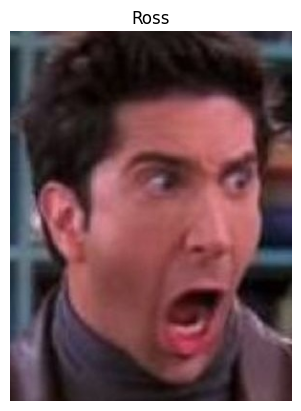

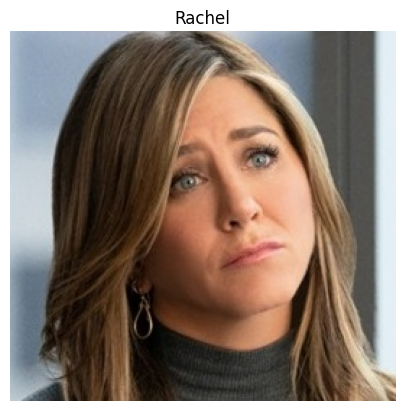

In [4]:
img = load_img(images_path + "/ross/train01.jpeg")
plt.imshow(img)
plt.axis("off")
plt.title("Ross")
plt.show()

plt.figure()

img = load_img(images_path + "/rachel/train30.jpeg")
plt.imshow(img)
plt.axis("off")
plt.title("Rachel")
plt.show()

## Processamento dos dados

In [5]:
className = glob(images_path + "/*")
NumberofClass = len(className)
print("NumberofClass:", NumberofClass)

NumberofClass: 6


In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  images_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
)

rescale_train = Rescaling(scale=1.0/255)
train_ds = train_ds.map(lambda image,label:(rescale_train(image),label))

val_ds = tf.keras.utils.image_dataset_from_directory(
  images_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
)

rescale_val = Rescaling(scale=1.0/255)
val_ds = val_ds.map(lambda image,label:(rescale_val(image),label))

Found 175 files belonging to 6 classes.
Using 140 files for training.
Found 175 files belonging to 6 classes.
Using 35 files for validation.


In [8]:
class_names = ['chandler', 'joey', 'monica', 'phoebe', 'rachel', 'ross']

## Rede InceptionV3

In [9]:
IncV3 = InceptionV3(include_top = False, weights = "imagenet",input_shape = (img_height,img_width,3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model = Sequential()

model.add(keras.layers.RandomFlip("horizontal"))
model.add(keras.layers.RandomRotation(0.2))
model.add(keras.layers.RandomZoom(0.3))

model.add(IncV3)
#model.add(keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)))

for layer in model.layers:
    layer.trainable = False


model.add(Flatten())

model.add(Dense(units = 2048, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = NumberofClass, activation = "softmax"))


## Compilação da rede

In [11]:
model.compile(optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss = "categorical_crossentropy", metrics = ["accuracy"])

## Treinamento

In [12]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 30,
                    batch_size = batch_size)
model.save_weights("friendsimages.weights.h5")


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.2071 - loss: 3.3817 - val_accuracy: 0.2571 - val_loss: 1.9310
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.1960 - loss: 2.7295 - val_accuracy: 0.3714 - val_loss: 1.5191
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3950 - loss: 2.2152 - val_accuracy: 0.4286 - val_loss: 1.8121
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3577 - loss: 1.9768 - val_accuracy: 0.5714 - val_loss: 1.1590
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5052 - loss: 1.5828 - val_accuracy: 0.5714 - val_loss: 1.0610
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.5095 - loss: 1.7034 - val_accuracy: 0.5714 - val_loss: 1.1437
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5586 - loss: 1.4666 - val_accuracy: 0.5714 - val_loss: 1.1742
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5065 - loss: 1.4645 - val_accuracy: 0.6286 - val_loss: 1.1257
Epoch 9/

In [26]:
model.load_weights("/content/friendsimages.weights.h5")

## Avaliação do resultado da rede

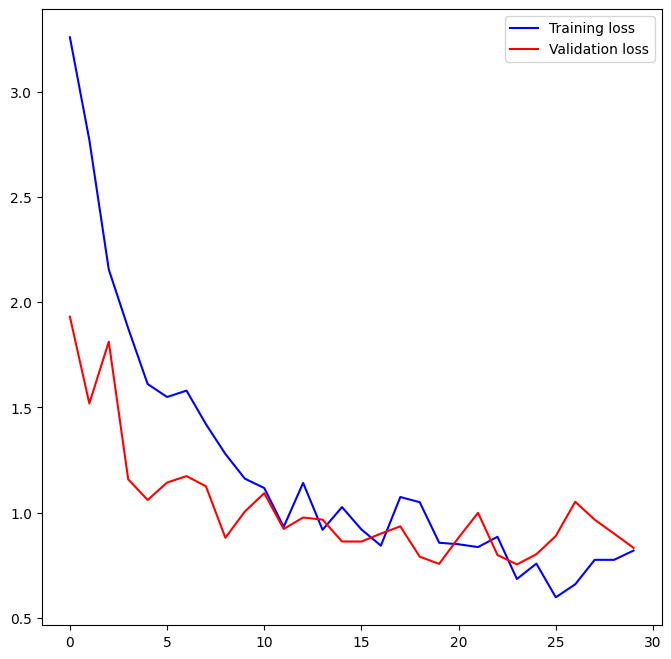

<Figure size 640x480 with 0 Axes>

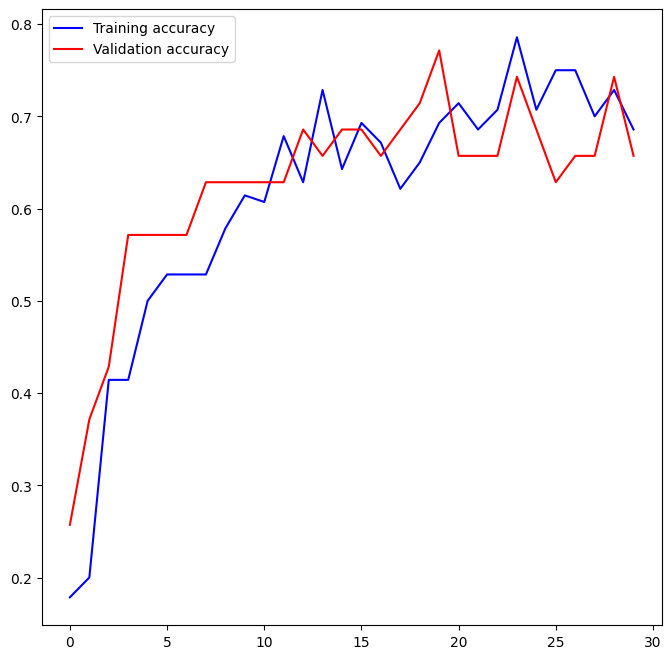

In [27]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

# Teste de predição

In [28]:
# Function to predict the class of an input image
def predict_class(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    #img = cv2.imread(image_path)
    #img = cv2.resize(img, (img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale pixel values
    img_array = np.vstack([img_array])

    # Make prediction
    predictions = model.predict(img_array)

    # Interpret predictions
    predicted_class_index = np.argmax(predictions)
    print(predicted_class_index)
    predicted_class_label = class_names[predicted_class_index]
    print(predicted_class_label)

    return predicted_class_label, predictions[0][predicted_class_index]

In [29]:
# Function to predict the class of an input image
def predict_class_arr(img_array):
    img_array = cv2.resize(img_array, (img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.  # Rescale pixel values
    img_array = np.vstack([img_array])

    # Make prediction
    predictions = model.predict(img_array)

    # Interpret predictions
    predicted_class_index = np.argmax(predictions)
    print(predicted_class_index)
    predicted_class_label = class_names[predicted_class_index]
    print(predicted_class_label)

    return predicted_class_label, predictions[0][predicted_class_index]

In [48]:
# Test with an input image
!rm -f facea.jpg
!wget -O facea.jpg 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRvfwiQDWweFDNfSKm7FS_WDYn0qDyZNL97Q&s'
!pwd
!ls
path1 = '/content/facea.jpg'
predicted_class, confidence = predict_class(path1)
print("Predicted class:", predicted_class)
print("Confidence:", confidence)

--2025-01-07 00:22:34--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRvfwiQDWweFDNfSKm7FS_WDYn0qDyZNL97Q&s
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.216.100, 173.194.216.139, 173.194.216.113, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.216.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6581 (6.4K) [image/jpeg]
Saving to: ‘facea.jpg’

facea.jpg           100%[===================>]   6.43K  --.-KB/s    in 0s      

2025-01-07 00:22:34 (19.8 MB/s) - ‘facea.jpg’ saved [6581/6581]

/content
allfriends.png	 friendsimages		   img.png
deploy.prototxt  friendsimages.tar	   res10_300x300_ssd_iter_140000.caffemodel
facea.jpg	 friendsimages.weights.h5  sample_data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2
monica
Predicted class: monica
Confidence: 0.40230095


#Detecção de rosto

In [49]:
!rm -f allfriends.jpg
!wget -O allfriends.png 'https://ichef.bbci.co.uk/ace/ws/640/cpsprodpb/646b/live/6573c010-79b9-11ef-b02d-c5f3b724a1ea.jpg.webp'

--2025-01-07 00:23:45--  https://ichef.bbci.co.uk/ace/ws/640/cpsprodpb/646b/live/6573c010-79b9-11ef-b02d-c5f3b724a1ea.jpg.webp
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 23.54.44.158, 2600:1408:ec00:a81::f33, 2600:1408:ec00:a89::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|23.54.44.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23550 (23K) [image/webp]
Saving to: ‘allfriends.png’

allfriends.png      100%[===================>]  23.00K  --.-KB/s    in 0.02s   

2025-01-07 00:23:45 (1.32 MB/s) - ‘allfriends.png’ saved [23550/23550]



In [50]:
image_file = 'allfriends.png'

900 506


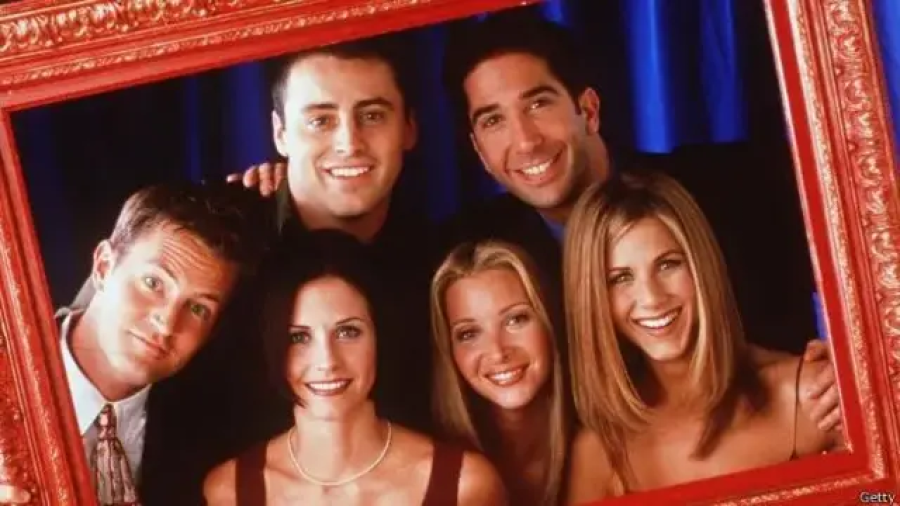

In [51]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
test_image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
test_image = imutils.resize(test_image, width=900)
(h, w) = test_image.shape[:2]
print(w,h)
cv2_imshow(test_image)

Usando a rede de deep learning da bibliotecca OpenCV para detecção de rostos. Para usá-la vamos baixar dois arquivos:

*   A definição da rede (deploy.prototxt)
*   Os pesos (res10_300x300_ssd_iter_140000.caffemodel)

In [52]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-01-07 00:23:59--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2025-01-07 00:23:59 (15.0 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-01-07 00:23:59--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Carga do modelo treinado e os pesos

In [58]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
modelw = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, modelw)

[INFO] loading model...


Carga da imagem, redimensionamento e normalização

In [59]:
# resize it to have a maximum width of 400 pixels
test_image = imutils.resize(test_image, width=900)
blob = cv2.dnn.blobFromImage(cv2.resize(test_image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

Passando a imagem pela rede para obter as detecções

In [60]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Percorrendo as detecções e desenhando uma caixa ao redor

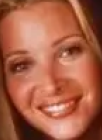

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
5
ross


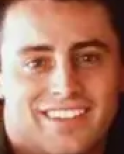

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
5
ross


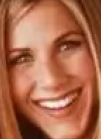

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
4
rachel


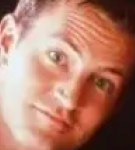

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1
joey


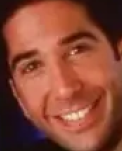

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
5
ross


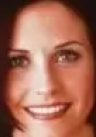

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2
monica


In [61]:
for i in range(0, detections.shape[2]):

	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		boxImg = test_image[startY:endY, startX:endX]
		cv2.imwrite('img.png', boxImg)
		cv2_imshow(boxImg)
		predicted_class_1, confidence_1 = predict_class('img.png')

		# draw the bounding box of the face along with the associated probability
		text = predicted_class_1
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(test_image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(test_image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

Mostrando a imagem resultante

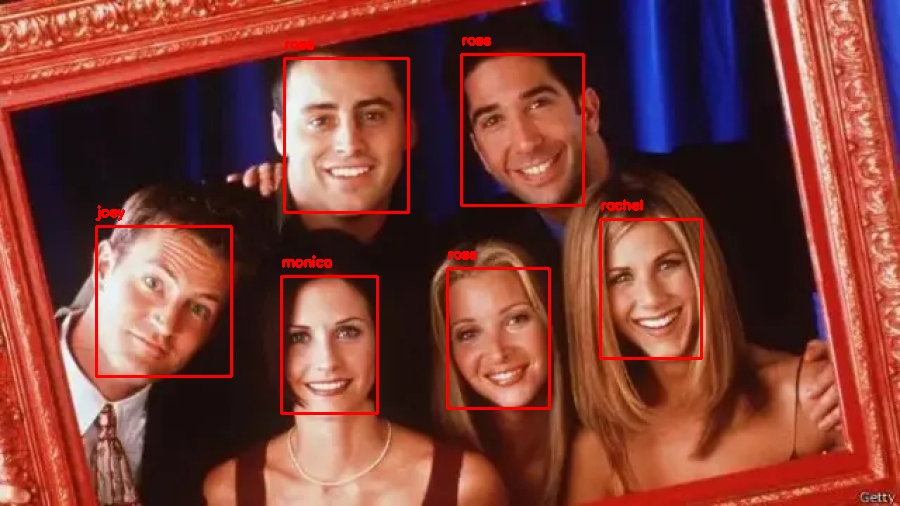

In [62]:
cv2_imshow(test_image)